# Variational Auto-encoder

This notebook presents a variational auto-encoder ([paper](https://arxiv.org/abs/1312.6114)) for trajectory generation.

In [1]:
import altair as alt

from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP
import pandas as pd
from tqdm import tqdm

import torch

from deep_traffic_generation.core.utils import traffic_from_data
from deep_traffic_generation.core.transforms import PyTMinMaxScaler

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [2]:
N_SAMPLES = 1000

In [3]:
dataset = TrafficDataset.from_file(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=PyTMinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    File location: ../deep_traffic_generation/data/traffic_15.pkl

In [4]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_14/checkpoints/epoch=497-step=1493.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_14/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(32,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(32,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(32,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(32,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [5]:
z, _ = model.encoder(dataset.data, [])
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [6]:
original, l, info = dataset[0]
_, _, reconstruction = model(original.unsqueeze(0), l)

data = torch.cat((original.unsqueeze(0).transpose(1, 2), reconstruction.detach().transpose(1, 2)))
data.size()

torch.Size([2, 200, 4])

In [7]:
data = data.view((data.shape[0], -1))
data = data.reshape((-1, 4))
data = dataset.scaler.inverse_transform(data)
data.shape

torch.Size([400, 4])

In [8]:
data = data.numpy().reshape((2, -1))

In [9]:
info = info.repeat(2, 1)
info.size()

torch.Size([2, 2])

In [10]:
# add latitude longitude info
# data = data.reshape((2, -1))
data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
traffic

(2, 802)


,count
flight_id,
TRAJ_0,200
TRAJ_1,200


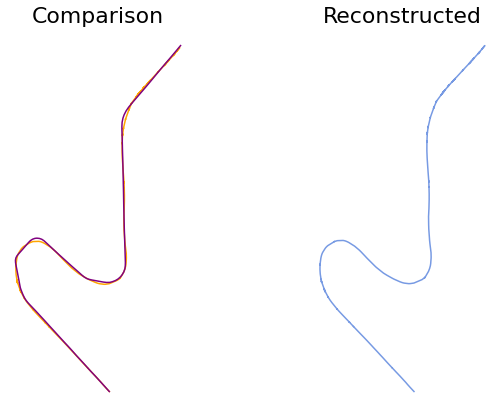

In [11]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

In [12]:
traffic[0].chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [13]:
traffic[1].chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [14]:
traffic[0].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [15]:
traffic[1].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

### Generation

In [14]:
p = torch.distributions.Normal(torch.zeros(model.hparams.encoding_dim), 1)
x_sim = p.sample_n(N_SAMPLES)
x_sim.size()

torch.Size([1000, 32])

In [15]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(4968, 32)

In [16]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(4968, 2)

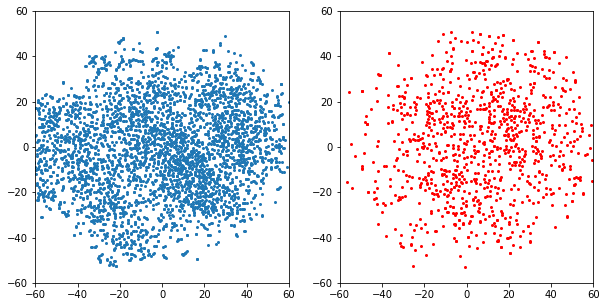

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z_embedded[:len(dataset), 0], z_embedded[:len(dataset), 1], s=4)
ax[1].scatter(z_embedded[len(dataset):, 0], z_embedded[len(dataset):, 1], s=4, c='red')

for ax_ in ax:
    ax_.set_xlim(-60, 60)
    ax_.set_ylim(-60, 60)

plt.show()

Find closest original trajectories

In [18]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: torch.Size([32, 1000])
X real: (32, 3968)


In [19]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [21]:
originals, _, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([1000, 200, 4])

In [22]:
data = originals.detach().numpy()
# data = data.reshape((-1, dataset.input_dim))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [23]:
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_original.data.columns:
    traffic_original = traffic_original.cumulative_distance().eval(desc="")

traffic_original

,count
flight_id,
TRAJ_0,200
TRAJ_702,200
TRAJ_691,200
TRAJ_692,200
TRAJ_693,200
TRAJ_694,200
TRAJ_695,200
TRAJ_696,200
TRAJ_697,200


Decode generated samples

In [24]:
outputs = model.decoder(torch.Tensor(x_sim), torch.Tensor([200]*N_SAMPLES))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([1000, 200, 4])

In [25]:
data = outputs.detach().numpy()
# data = data.reshape((-1, dataset.input_dim))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [26]:
# add latitude longitude info
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
t_gen = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_generated.data.columns:
    t_gen = (
        t_gen
        .cumulative_distance()
        .rename(columns=dict(compute_gs="groundspeed", compute_track="track"))
        .eval(desc="")
    )

t_gen

,count
flight_id,
TRAJ_0,200
TRAJ_702,200
TRAJ_691,200
TRAJ_692,200
TRAJ_693,200
TRAJ_694,200
TRAJ_695,200
TRAJ_696,200
TRAJ_697,200


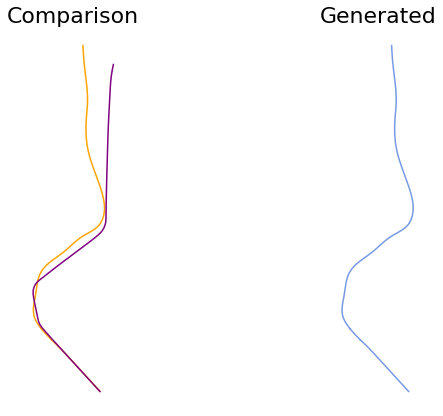

In [27]:
flight_id = 20
generated = t_gen[f"TRAJ_{flight_id}"]
original = traffic_original[f"TRAJ_{flight_id}"]
    
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    generated.plot(ax[0], c="orange", label="generated")
    original.plot(ax[0], c="purple", label="closest original")
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [28]:
generated.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [29]:
generated.chart().encode(alt.Y("groundspeed"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [30]:
generated.chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [31]:
t_gen.to_csv("./outputs/vae_gen.csv")

### Douglas-Peucker

In [32]:
simplified_t_gen = (
    t_gen
    .simplify(tolerance=1e3)
    .eval(desc="")
)
simplified_t_gen.data

  0%|          | 0/1000 [00:00<?, ?it/s]

,track,groundspeed,altitude,timedelta,latitude,longitude,flight_id,callsign,icao24,timestamp
0,201.374603,327.060547,14865.016602,-0.004268,48.078733,8.674639,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-10 14:43:16.995732188+00:00
58,204.854553,244.663788,9705.526367,203.032425,47.819483,8.574648,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-10 14:46:40.032424927+00:00
122,189.731186,191.748245,5320.533691,427.187836,47.659382,8.359815,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-10 14:50:24.187835693+00:00
148,146.624588,207.178726,4297.546387,517.695984,47.581643,8.400333,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-10 14:51:54.695983887+00:00
199,137.111526,134.275711,1595.352539,696.113525,47.483467,8.534265,TRAJ_0,TRAJ_0,TRAJ_0,2021-09-10 14:54:53.113525391+00:00
...,...,...,...,...,...,...,...,...,...,...
199883,240.265671,233.339767,7624.391602,336.007996,47.744600,8.516164,TRAJ_999,TRAJ_999,TRAJ_999,2021-09-10 14:48:53.007995604+00:00
199904,234.948196,223.826157,5978.302734,421.799194,47.722277,8.388238,TRAJ_999,TRAJ_999,TRAJ_999,2021-09-10 14:50:18.799194336+00:00
199923,194.559799,188.234924,5104.435059,497.888885,47.659245,8.338829,TRAJ_999,TRAJ_999,TRAJ_999,2021-09-10 14:51:34.888885498+00:00
199930,149.598648,182.221970,4915.440430,527.168701,47.635608,8.344675,TRAJ_999,TRAJ_999,TRAJ_999,2021-09-10 14:52:04.168701172+00:00


In [33]:
simplified_t_gen.to_csv("./outputs/dp_vae_gen.csv")

### Navigational Points

In [34]:
navpoints_t_gen = pd.concat([
    flight
    .compute_navpoints()
    .assign(
        flight_id=flight.flight_id,
        callsign=flight.callsign,
        icao24=flight.icao24,
        registration=flight.registration,
        typecode=flight.typecode,
        latitude_0=flight.data.iloc[0].latitude,
        longitude_0=flight.data.iloc[0].longitude,
        altitude_0=flight.data.iloc[0].altitude,
        track_0=flight.data.iloc[0].track,
        groundspeed_0=flight.data.iloc[0].groundspeed,
    )
    .drop(columns=[
        "altitude",
        "description",
        "frequency",
        "magnetic_variation"
    ])
    for flight in tqdm(t_gen)
])
navpoints_t_gen.head()

100%|██████████| 1000/1000 [13:01<00:00,  1.28it/s]


,start,stop,duration,navaid,distance,shift_mean,shift_meanp,name,type,latitude,...,flight_id,callsign,icao24,registration,typecode,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2021-09-10 14:44:12.939758301+00:00,2021-09-10 14:46:15.133178711+00:00,0 days 00:02:02.193420410,ZH578,21.251101,0.186649,0.206649,ZH578,FIX,47.502694,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.078733,8.674639,14865.016602,201.374603,327.060547
1,2021-09-10 14:51:09.151519775+00:00,2021-09-10 14:51:47.504394531+00:00,0 days 00:00:38.352874756,ZH578,5.716136,0.017796,0.037796,ZH578,FIX,47.502694,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.078733,8.674639,14865.016602,201.374603,327.060547
2,2021-09-10 14:47:00.597015381+00:00,2021-09-10 14:48:04.459472656+00:00,0 days 00:01:03.862457275,D335O,5.273968,0.040715,0.060715,D335O,FIX,47.679386,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.078733,8.674639,14865.016602,201.374603,327.060547
3,2021-09-10 14:48:10.621551514+00:00,2021-09-10 14:49:30.933685303+00:00,0 days 00:01:20.312133789,ZH065,6.885595,0.051938,0.071938,ZH065,FIX,47.616278,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.078733,8.674639,14865.016602,201.374603,327.060547
4,2021-09-10 14:52:12.701782227+00:00,2021-09-10 14:54:25.406921387+00:00,0 days 00:02:12.705139160,D337B,0.640192,0.018296,0.038296,D337B,FIX,47.488086,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.078733,8.674639,14865.016602,201.374603,327.060547


In [35]:
navpoints_t_gen.to_csv("./outputs/nav_vae_gen.csv")